# Visualisation des données de la campagne "visite page produit" de l'annonceur 2

## Visualisation des données brutes

In [34]:
# fichiers contenant les fonctions utiles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels
from premiere_analyse import *
from part1 import *
from part2 import *
from part3 import *
from testZ import *
import scipy.stats as st
import statsmodels.stats as sms
from IPython.display import display, Markdown
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.stattools as sto
from pandas import DataFrame
import seaborn as sns
import warnings

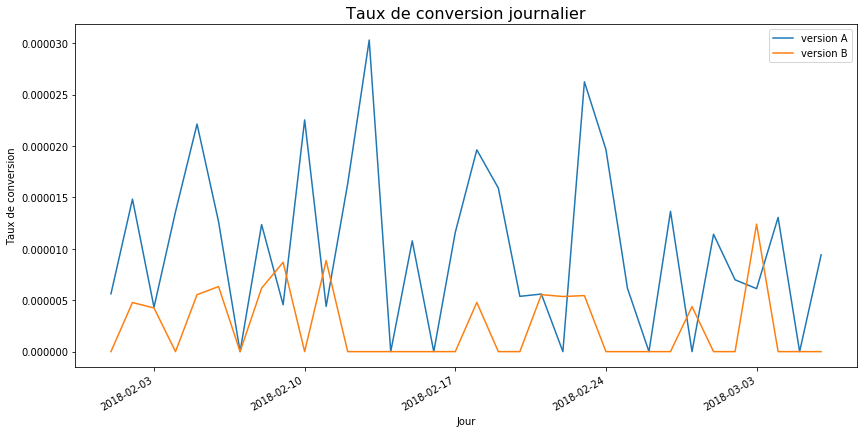

In [2]:
datasetA = pd.read_hdf('/Users/guillaumeshi/PycharmProjects/1000mercis/Data/annonceur2/annonceur2_daily.hdf', key='visite_page_produitA')
datasetB = pd.read_hdf('/Users/guillaumeshi/PycharmProjects/1000mercis/Data/annonceur2/annonceur2_daily.hdf', key='visite_page_produitB')
plt.rcParams["figure.figsize"] = (14,7)
fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.plot_date(datasetA.index, datasetA['conv_rate'], marker='', linestyle='-')
plt.plot(datasetA.index, datasetB['conv_rate'])
plt.xlabel('Jour')
plt.ylabel('Taux de conversion')
plt.title('Taux de conversion journalier', fontsize=16)
plt.legend(['version A', 'version B'], loc='best')
plt.show()

On voit ainsi que la version B semble moins efficace que la version A, ce qui reste à démontrer via un test d'hypothèses.

## Différence relative des taux de conversion

On regarde si le niveau d'agrégation (jour ou semaine) permettrait d'établir une différence relative importante entre les taux de conversions issus des deux versions. On notera toutefois que cette différence relative ne peut être calculée pour certains jours puisque le taux de conversion de la version A est parfois nul.

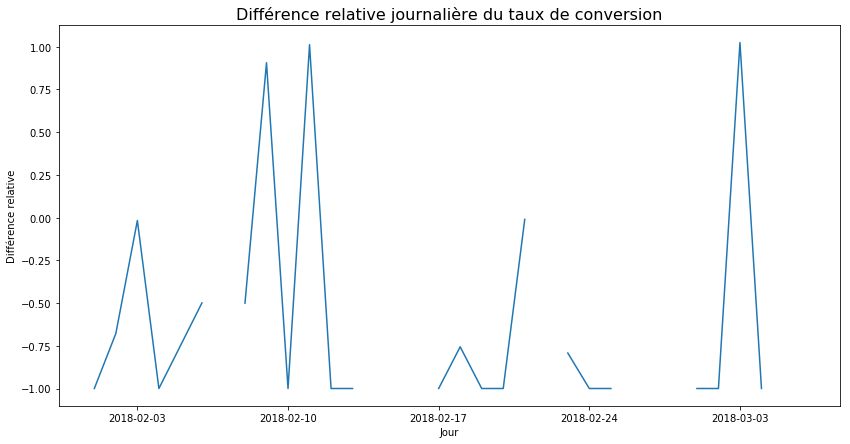

In [3]:
daily_relative_difference = (datasetB['conv_rate'] - datasetA['conv_rate']) / datasetA['conv_rate']

plt.rcParams["figure.figsize"] = (14,7)
plt.plot(datasetA.index, daily_relative_difference)
plt.xlabel('Jour')
plt.ylabel('Différence relative')
plt.title('Différence relative journalière du taux de conversion', fontsize=16)
plt.show()

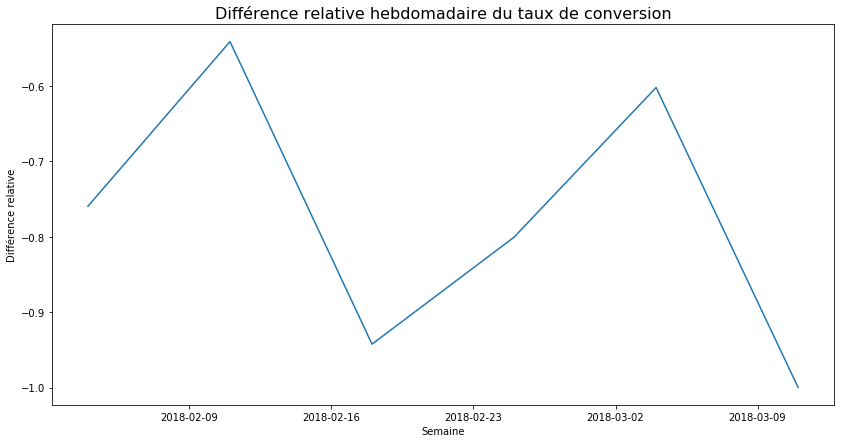

In [4]:
weekly_datasetA = datasetA.resample('W').sum()
weekly_datasetA['conv_rate'] = weekly_datasetA['n_convs'] / weekly_datasetA['total_impressions']

weekly_datasetB = datasetB.resample('W').sum()
weekly_datasetB['conv_rate'] = weekly_datasetB['n_convs'] / weekly_datasetB['total_impressions']

weekly_relative_difference = (weekly_datasetB - weekly_datasetA) / weekly_datasetA

plt.rcParams["figure.figsize"] = (14,7)
plt.plot(weekly_relative_difference.index, weekly_relative_difference['conv_rate'])
plt.xlabel('Semaine')
plt.ylabel('Différence relative')
plt.title('Différence relative hebdomadaire du taux de conversion', fontsize=16)
plt.show()

Il semblerait ainsi que sur la plage temporelle étudiée, la différence relative était négative décroisse jusqu'à atteindre la valeur -1 : d'un point de vue hebdomadaire, le taux de conversion sous la version B était inférieur à celui sous la version A, et vers la fin de la campagne, la version B n'engendrait presque plus de conversion.

# Analyse des données de la campagne "visite page produit" de l'annonceur 2

## Stationnarité des données

On s'intéresse dans un premier temps à la stationnarité des données : le taux de conversion dépend-t-il du jour de la visite ? Y a-t-il des jours où le taux de conversion semble influencer la conversion des utilisateurs ?

In [5]:
adf_test(datasetA['conv_rate'])

,Results of Augmented Dickey-Fuller test:
test statistic,-6.559938e+00
p-value,8.430668e-09
# of lags,0.000000e+00
# of observations,3.300000e+01
Critical Value (1%),-3.646135e+00
Critical Value (5%),-2.954127e+00
Critical Value (10%),-2.615968e+00


In [6]:
adf_test(datasetB['conv_rate'])

,Results of Augmented Dickey-Fuller test:
test statistic,-6.159365e+00
p-value,7.236679e-08
# of lags,0.000000e+00
# of observations,3.300000e+01
Critical Value (1%),-3.646135e+00
Critical Value (5%),-2.954127e+00
Critical Value (10%),-2.615968e+00


Un test de Dickey-Fuller sur la série temporelle des taux de conversions journaliers pour la version A indique que celle-ci est stationnaire (p-value inférieure à 1%). De même, la série temporelle pour la version B indique que celle-ci est stationnaire.

In [7]:
adf_test(list(np.diff(datasetA['conv_rate'])))

,Results of Augmented Dickey-Fuller test:
test statistic,-6.306489e+00
p-value,3.313809e-08
# of lags,3.000000e+00
# of observations,2.900000e+01
Critical Value (1%),-3.679060e+00
Critical Value (5%),-2.967882e+00
Critical Value (10%),-2.623158e+00


In [8]:
adf_test(list(np.diff(datasetB['conv_rate'])))

,Results of Augmented Dickey-Fuller test:
test statistic,-8.350228e+00
p-value,3.008578e-13
# of lags,1.000000e+00
# of observations,3.100000e+01
Critical Value (1%),-3.661429e+00
Critical Value (5%),-2.960525e+00
Critical Value (10%),-2.619319e+00


On a toujours stationnarité des séries temporelles après différenciation.

## Saisonnalité des données

On essaie ensuite de voir si de la série temporelle on peut dégager certaines tendances : tendance globale, composante saisonnière et résidu, le but étant de voir si les taux de conversion peuvent être affectés par certains cycles temporels, et, le cas échéant, dans quelle mesure. Puisque nous travaillons avec des taux de conversion dont les valeurs peuvent être nulles, on se focalisera essentiellement sur des modèles additifs.

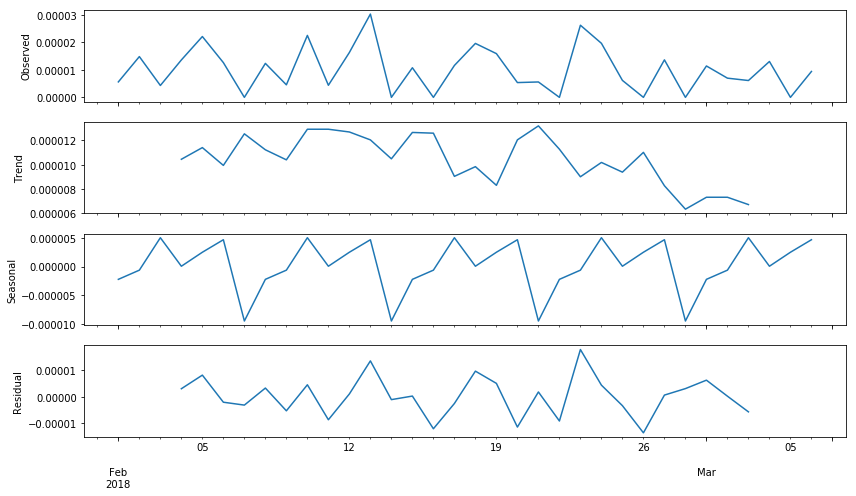

In [9]:
conversion_rate = datasetA['conv_rate']
conversion_rate.index = pd.to_datetime(conversion_rate.index)
decomposition = statsmodels.tsa.seasonal.seasonal_decompose(conversion_rate, model="additive")
plt.rcParams["figure.figsize"] = (12,7)
decomposition.plot()
plt.show()

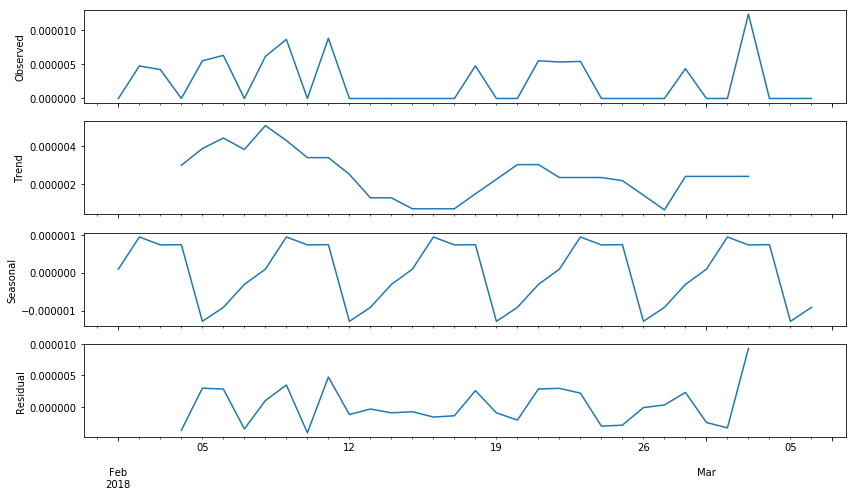

In [10]:
conversion_rate = datasetB['conv_rate']
conversion_rate.index = pd.to_datetime(conversion_rate.index)
decomposition = statsmodels.tsa.seasonal.seasonal_decompose(conversion_rate, model="additive")
plt.rcParams["figure.figsize"] = (12,7)
decomposition.plot()
plt.show()

# Z-test : conclusion quant à l'efficacité du test A/B mené

## Z-test global

Enfin, on conduit un Z-test destiné à mesurer l'efficacité statistique du test A/B mené. Mathématiquement, cela se traduit par la comparaison de l'hypothèse nulle H0 : "le taux de conversion sous version A est le même que celui sous version B" avec l'hypothèse H1 : "le taux de conversion sous version A est différent que celui sous version B". En d'autres termes, l'hypothèse H1 traduit le fait que la version B a bel et bien une influence sur le taux de conversion.

In [11]:
from scipy.stats import norm
pA = sum(datasetA['n_convs']) / sum(datasetA['total_impressions'])
pB = sum(datasetB['n_convs']) / sum(datasetB['total_impressions'])

nA = sum(datasetA['total_impressions'])
nB = sum(datasetB['total_impressions'])

Z_value = (pA - pB) / np.sqrt(pA * (1 - pA) / nA + pB * (1 - pB) / nB)
p_val = 1 - norm.cdf(abs(Z_value)) + norm.cdf(-abs(Z_value))

print(p_val)

7.947137968280094e-08


On obtient une p-valeur inférieure aux seuils usuels de 10%, 5% ou 1%. On rejette donc l'hypothèse H0 et on en déduit alors que **la version B semble avoir plus d'influence sur le taux de conversion que la version A. En effet, comme vu précédemment, la version B semble moins efficace que la version A**.

## Z-test cumulé (pas journalier)

On s'intéresse maintenant aux **données cumulées** : en regardant l'ensemble des informations dont on dispose du jour 1 de la campagne publicitaire au jour n, peut-on voir une certaine tendance quant au test d'hypothèses ?

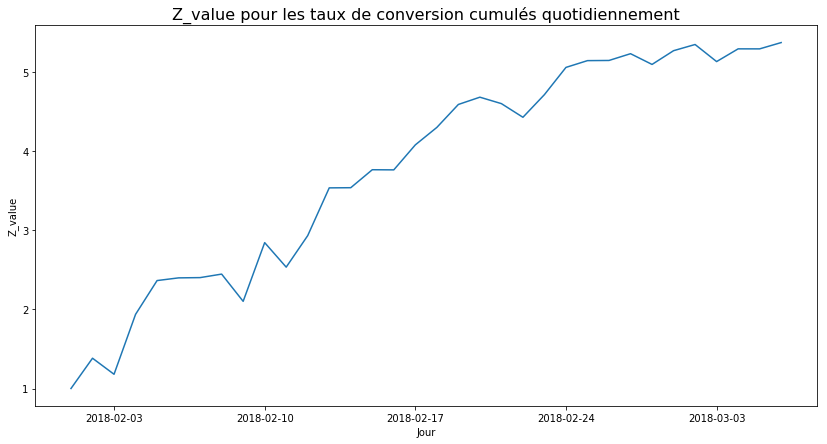

In [12]:
daily_cumsum_datasetA = datasetA[['total_impressions', 'n_convs']].cumsum()
daily_cumsum_datasetB = datasetB[['total_impressions', 'n_convs']].cumsum()
daily_cumsum_datasetA['conv_rate'] = daily_cumsum_datasetA['n_convs'] / daily_cumsum_datasetA['total_impressions']
daily_cumsum_datasetB['conv_rate'] = daily_cumsum_datasetB['n_convs'] / daily_cumsum_datasetB['total_impressions']

Z_value_1D = []
p_value_1D = []

for date in daily_cumsum_datasetA.index:
    pA = daily_cumsum_datasetA.loc[date]['conv_rate']
    nA = daily_cumsum_datasetA.loc[date]['total_impressions']
    pB = daily_cumsum_datasetB.loc[date]['conv_rate']
    nB = daily_cumsum_datasetB.loc[date]['total_impressions']
    Z_value_1D.append((pA-pB)/np.sqrt(pA*(1-pA)/nA + pB*(1-pB)/nB))
    p_value_1D.append(1 - norm.cdf(abs(Z_value_1D[-1])) + norm.cdf(-abs(Z_value_1D[-1])))

        
plt.rcParams["figure.figsize"] = (14,7)
plt.plot(daily_cumsum_datasetA.index, Z_value_1D)
plt.xlabel('Jour')
plt.ylabel('Z_value')
plt.title('Z_value pour les taux de conversion cumulés quotidiennement', fontsize=16)
plt.show()

La Z-value est toujours positive. Cette valeur était du signe de la différence entre le taux de conversion sous version A et celui sous version B, cela nous indique qu'a priori, la version A était meilleure que la version B. Il reste à voir si cela peut être confirmé ou infirmé statistiquement. On s'intéresse ainsi à l'évoluation de la p-valeur.

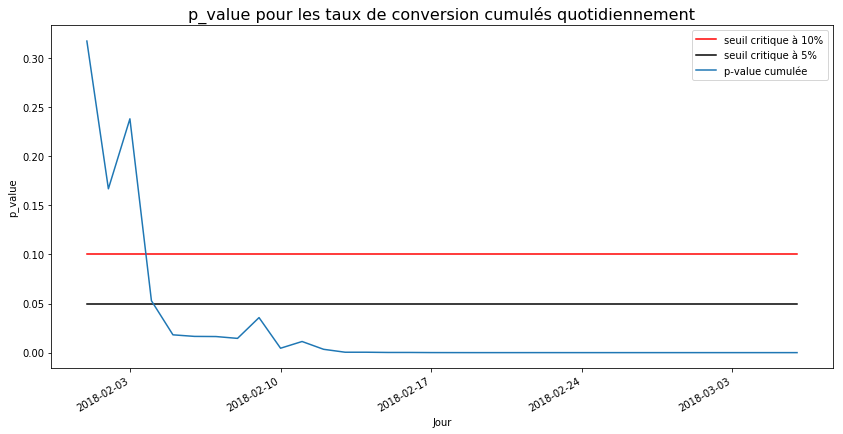

In [13]:
plt.rcParams["figure.figsize"] = (14,7)

fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.plot_date(datasetA.index, [0.1]*len(datasetA.index), marker='', linestyle='-', c='red')
ax.plot_date(datasetA.index, [0.05]*len(datasetA.index), marker='', linestyle='-', c='black')
plt.plot(daily_cumsum_datasetA.index, p_value_1D)
plt.xlabel('Jour')
plt.ylabel('p_value')
plt.title('p_value pour les taux de conversion cumulés quotidiennement', fontsize=16)
plt.legend(['seuil critique à 10%', 'seuil critique à 5%', 'p-value cumulée'], loc='best')
plt.show()

On voit ainsi que la p-value cumulée se situe au-delà du seuil critique à 5% jusqu'au 4 février 2018 environ, soit approximativement le début de la campagne. En d'autres termes, l'hypothèse nulle "la version B n'a pas plus d'influence que la version A sur le taux de conversion" aurait été acceptée si la campagne avait pris fin avant le 4 février. Néanmoins, il se trouve que la p-value descend sous le seuil critique de 5% après cette date, et qu'elle reste très basse jusqu'à la fin de la campagne. Autrement dit, une vue globale de la campagne après le 4 février permet de rejeter l'hypothèse nulle et donc d'**accepter l'hypothèse selon laquelle la version B donne de moins bons résultats que la version A**.

Avec un seuil critique à 10%, on aurait tout de même rejeté l'hypothèse nulle dès le 4 février. En fait, on remarque d'ailleurs une chute brutale de la p-value cumulée à partir du 3 février. Au regard du graphique montrant l'évolution temporelle de la Z-value cumulée, cela signifie concrètement que **dès le 4 février, on avait suffisamment de significativité (que ce soit à 5% ou 10% voire 20%) pour en déduire que la version B était moins performante que la version A**, et que cette remarque persiste jusqu'à la fin de la campagne.

## Z-test cumulé (pas de 3 jours)

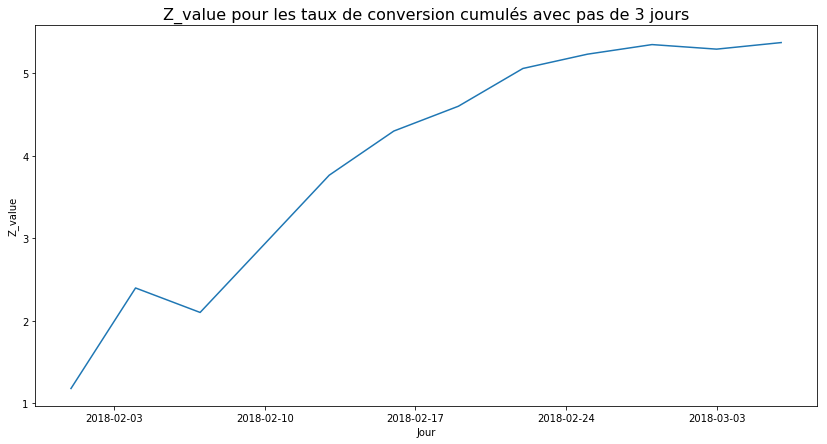

In [14]:
def cumulated_dataset_freq(dataset, frequency):  # dataset cumulé avec un pas de frequency jours
    cumulated_dataset = dataset.resample(frequency).sum().cumsum()
    cumulated_dataset['conv_rate'] = cumulated_dataset['n_convs'] / cumulated_dataset['total_impressions']
    return cumulated_dataset

frequency = '3D'

cumulated_datasetA = cumulated_dataset_freq(datasetA, frequency)
cumulated_datasetB = cumulated_dataset_freq(datasetB, frequency)

Z_value_3D = []
p_value_3D = []

for date in cumulated_datasetA.index:
    pA = cumulated_datasetA.loc[date]['conv_rate']
    nA = cumulated_datasetA.loc[date]['total_impressions']
    pB = cumulated_datasetB.loc[date]['conv_rate']
    nB = cumulated_datasetB.loc[date]['total_impressions']
    Z_value_3D.append((pA-pB)/np.sqrt(pA*(1-pA)/nA + pB*(1-pB)/nB))
    p_value_3D.append(1 - norm.cdf(abs(Z_value_3D[-1])) + norm.cdf(-abs(Z_value_3D[-1])))
    
plt.rcParams["figure.figsize"] = (14,7)
plt.plot(cumulated_datasetA.index, Z_value_3D)
plt.xlabel('Jour')
plt.ylabel('Z_value')
plt.title(f'Z_value pour les taux de conversion cumulés avec pas de {frequency[0]} jours', fontsize=16)
plt.show()

L'évolution de la Z-value est ainsi similaire à celle trouvée avec un pas quotidien. En effet, en prenant une fenêtre temporelle plus large pour regarder le cumul des données, on obtient une courbe plus lissée car celle-ci agrège les données à un plus haut niveau. L'allure reste toutefois semblable à celle où la fenêtre est plus réduite (et donc plus précise). Intéressons maintenant l'évolution de la p-value : **une fenêtre temporelle de 3 jours pour le cumul des données change-t-il la significativité du test, et donc la conclusion finale ?**

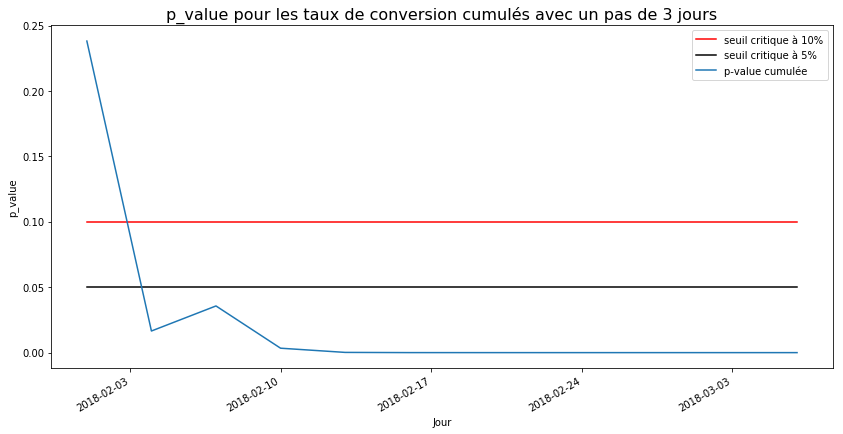

In [15]:
plt.rcParams["figure.figsize"] = (14,7)

fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.plot_date(cumulated_datasetA.index, [0.1]*len(cumulated_datasetA.index), marker='', linestyle='-', c='red')
ax.plot_date(cumulated_datasetA.index, [0.05]*len(cumulated_datasetA.index), marker='', linestyle='-', c='black')
plt.plot(cumulated_datasetA.index, p_value_3D)
plt.xlabel('Jour')
plt.ylabel('p_value')
plt.title(f'p_value pour les taux de conversion cumulés avec un pas de {frequency[0]} jours', fontsize=16)
plt.legend(['seuil critique à 10%', 'seuil critique à 5%', 'p-value cumulée'], loc='best')
plt.show()

Une fois de plus, on voit que la p-value du Z-test cumulé chute brutalement au début de la campagne publicitaire : cela signifie que dès le début, une version se démarque de l'autre par un taux de conversion sensiblement plus élevé. **Une observation globale des données à partir du 4 février suggère que la version A engendre un meilleur taux de conversion que la version B, et que cette remarque peut être affirmée avec un niveau de significativité quelconque (5%, 10% etc)**. De plus, la p-value restant très en-dessous du seuil critique à 5% pour toute la durée du test, on peut aussi affirmer qu'**à n'importe quel moment postérieur au 4 février, la version A était meilleure que la version B en termes de taux de conversion**.

# Modèles ARMA pour prédiction de la Z-value et p-value

In [74]:
series = pd.Series(Z_value_1D)

def arma_model_selection_stationary(series, max_ar=4, max_ma=4):
    assert not series.isnull().any()
    order_select = sto.arma_order_select_ic(
        series.values,
        ic=['aic', 'bic'],
        max_ar=max_ar,
        max_ma=max_ma
    )
    
    ### AIC ###
    order_aic = order_select['aic'].values
    list_aic = [order_select['aic'][i][j] for j in range(0, max_ar+1) for i in range(0, max_ma+1)]
    list_order_aic = [(j,i) for j in range(0,max_ar+1) for i in range(0, max_ma+1)]
    
    list_order_aic = [x for _,x in sorted(zip(list_aic,list_order_aic))]
    list_aic.sort()
    
    order_aic_stationary = None
    
    for order_aic in list_order_aic:
        try:
            ARIMA(series.values, order=(order_aic[0], 0, order_aic[1])).fit()
            order_aic_stationary = order_aic
            break
        except Exception as e:
            if isinstance(e, ValueError):
                pass
    
    aic_stationary = list_aic[list_order_aic.index(order_aic_stationary)]
    
    ### BIC ###
    order_bic = order_select['bic'].values
    list_bic = [order_select['bic'][i][j] for j in range(0, max_ar+1) for i in range(0, max_ma+1)]
    list_order_bic = [(j,i) for j in range(0,max_ar+1) for i in range(0, max_ma+1)]
    
    list_order_bic = [x for _,x in sorted(zip(list_bic,list_order_bic))]
    list_bic.sort()
    
    order_bic_stationary = None
    
    for order_bic in list_order_bic:
        try:
            ARIMA(series.values, order=(order_bic[0], 0, order_bic[1])).fit()
            order_bic_stationary = order_bic
            break
        except Exception as e:
            if isinstance(e, ValueError):
                pass
    
    bic_stationary = list_bic[list_order_bic.index(order_bic_stationary)]
    
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    sns.heatmap(order_select["aic"])
    plt.xlabel("Ordre MA")
    plt.ylabel("Ordre AR")
    plt.title("Résultats AIC")

    plt.subplot(1, 2, 2)
    sns.heatmap(order_select["bic"])
    plt.xlabel("Ordre MA")
    plt.ylabel("Ordre AR")
    plt.title("Résultats BIC")

    plt.suptitle(f"max_ar={max_ar}, max_ma={max_ma}")
    plt.show();

    print(
        "AIC meilleur modèle stationnaire : AR={}, MA={}, AIC={} ".format(
            order_aic_stationary[0], order_aic_stationary[1],
            aic_stationary
        )
    )
    print(
        "BIC meilleur modèle stationnaire : AR={}, MA={}, BIC={} ".format(
            order_bic_stationary[0], order_bic_stationary[1],
            bic_stationary
        )
    )

    return order_aic_stationary, order_bic_stationary

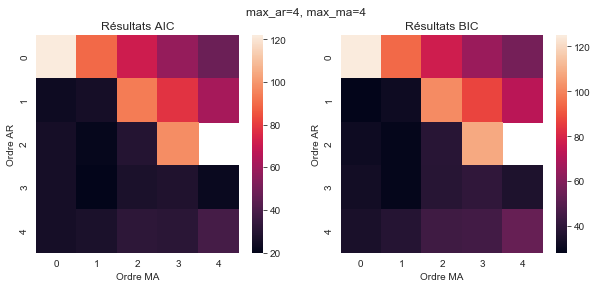

AIC meilleur modèle stationnaire : AR=3, MA=1, AIC=19.86927751102526 
BIC meilleur modèle stationnaire : AR=1, MA=0, BIC=28.209231541868505 


In [70]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

##################################### PARAMETRES #####################################
max_ar = 4
max_ma = 4
######################################################################################

aic_min_order, bic_min_order = arma_model_selection_stationary(series, max_ar=max_ar, max_ma=max_ma)

# Meilleur modèle selon AIC

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   34
Model:                     ARMA(3, 1)   Log Likelihood                  -3.935
Method:                       css-mle   S.D. of innovations              0.245
Date:                Sat, 09 Feb 2019   AIC                             19.869
Time:                        22:57:37   BIC                             29.027
Sample:                             0   HQIC                            22.992
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7942      0.983      2.842      0.008       0.867       4.721
ar.L1.y        1.6647      0.165     10.061      0.000       1.340       1.989
ar.L2.y       -0.3470      0.331     -1.049      0.3

## Erreurs sur la période d'entraînement

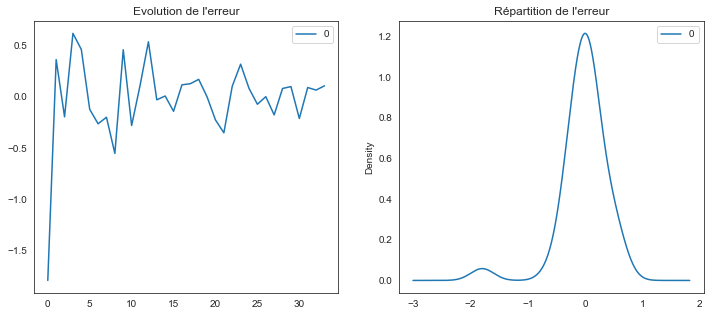

# Meilleur modèle selon BIC

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   34
Model:                     ARMA(1, 0)   Log Likelihood                  -8.815
Method:                       css-mle   S.D. of innovations              0.296
Date:                Sat, 09 Feb 2019   AIC                             23.630
Time:                        22:57:37   BIC                             28.209
Sample:                             0   HQIC                            25.192
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2795      1.857      1.766      0.087      -0.360       6.919
ar.L1.y        0.9891      0.014     68.508      0.000       0.961       1.017
                                    Roots           

## Erreurs sur la période d'entraînement

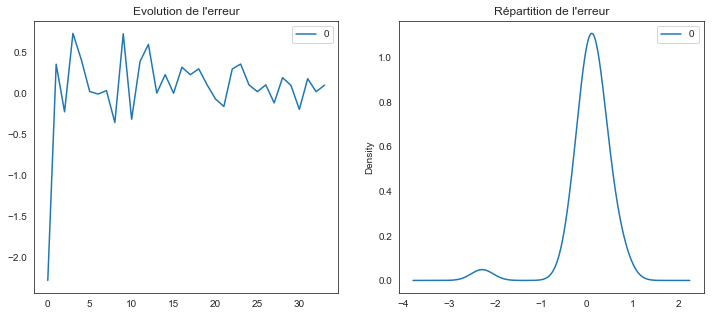

In [71]:
display(Markdown("# Meilleur modèle selon AIC"))
arma_summary(p=aic_min_order[0], q=aic_min_order[1], y_true=series.values)
if aic_min_order != bic_min_order:  
    display(Markdown("# Meilleur modèle selon BIC"))
    arma_summary(p=bic_min_order[0], q=bic_min_order[1], y_true=series.values)

### Zoom sur un modèle en particulier

Pour un modèle donné, est-ce que ce modèle est pertinent ? Regarder les p-valeurs des coefficients. 

Dans cette section on a construit le modèle à partir de l'ensemble des données. Mais quelles sont les prévisions selon le modèle sur les données existantes (in-sample)? 
On réalise des prédictions de `pred_start` à `pred_end` (None donne la fin de la période)
On peut distinguer deux types de prévisions : 
+ 1-step-ahead : on utilise toutes les données jusqu'à J-1
+ Dynamic : à partir de pred_start on utilise les variables prédites comme entrées
    + C'est ce mode qui nous intéresse car on aimerait faire des prédictions pour des horizons lointains sans avoir à faire le test A/B en réel

train_ratio= 0.25


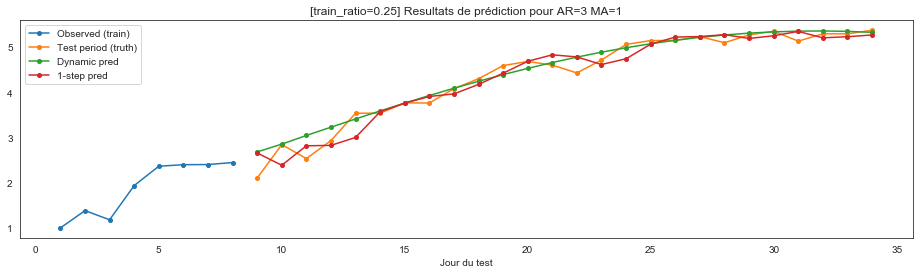

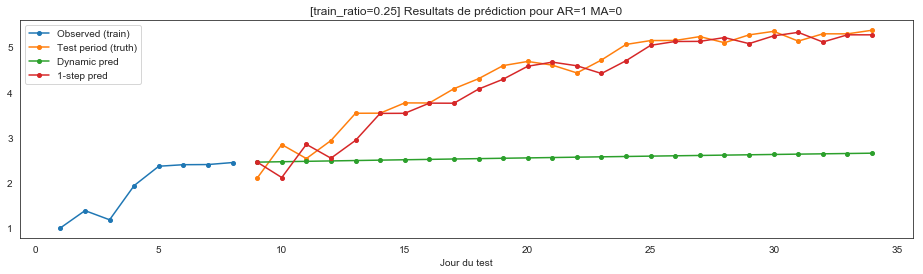

train_ratio= 0.5


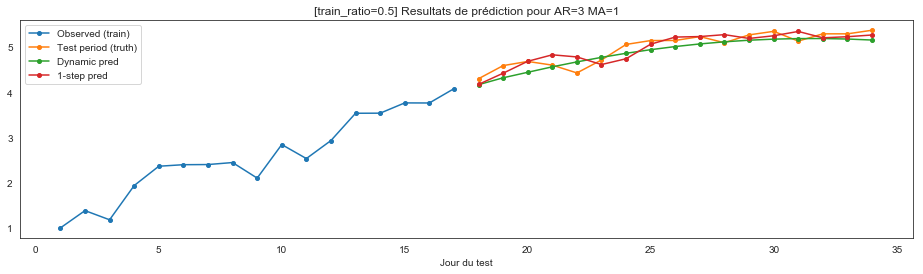

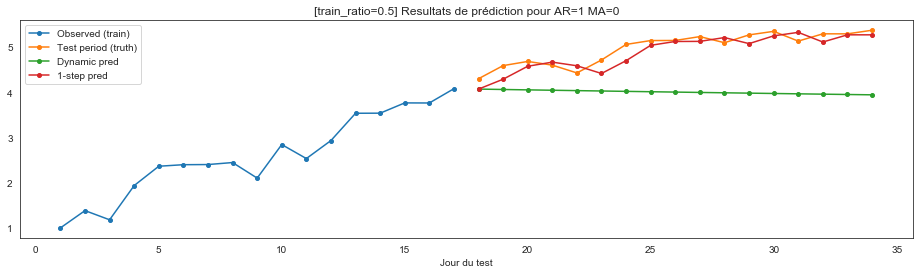

train_ratio= 0.75


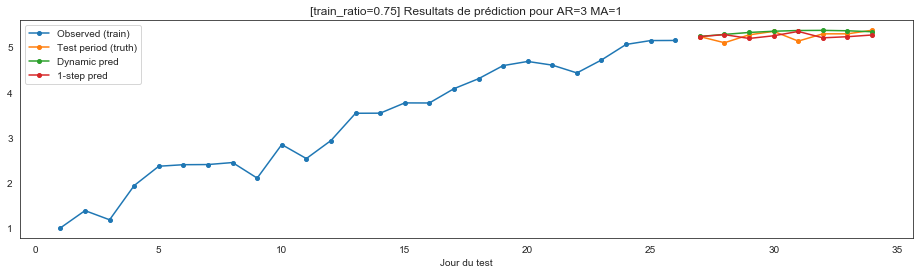

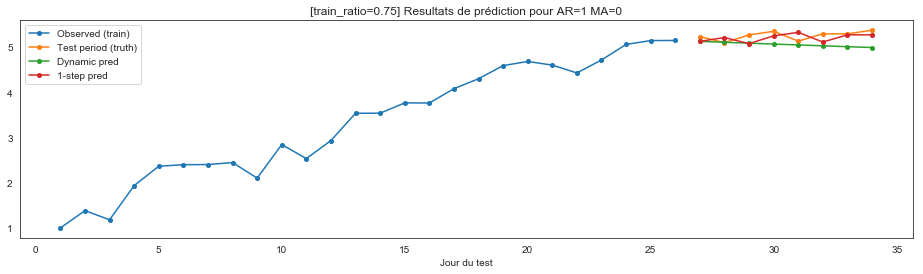

In [72]:
for train_ratio in [0.25, 0.5, 0.75]:
    print("train_ratio=", train_ratio)
    in_sample_prediction(p=aic_min_order[0], q=aic_min_order[1], y_true=series.values, train_ratio=train_ratio)
    if aic_min_order != bic_min_order:    
        in_sample_prediction(p=bic_min_order[0], q=bic_min_order[1], y_true=series.values, train_ratio=train_ratio)

Globalement, la prédiction dynamique semble bonne dans le sens où elle semble épouser la courbe donnant les valeurs réelles, et ceci quelle que soit la proportion de données prise comme données d'apprentissage (25%, 50%, 75%). On observe toutefois que la prédiction dynamique semble meilleure pour un modèle ARMA(3,1).

Il convient toutefois de nuancer ce résultat positif : un modèle ARMA semble donner de bons résultats prédictifs dynamiques pour ce cas précis car le Z-value est (à peu près) strictement croissante, si bien que la prédiction est "plus aisée", cela ne serait probablement pas le cas si la Z-value exhiberait une tendance puis une autre. Par exemple, si la Z-value était strictement croissante jusqu'au 20e jour et chuterait à partir de ce moment, on aurait sans doute des résultats prédictifs peu concordants.

### b. Etude sur la p-value

## Analyse classique d'une ST

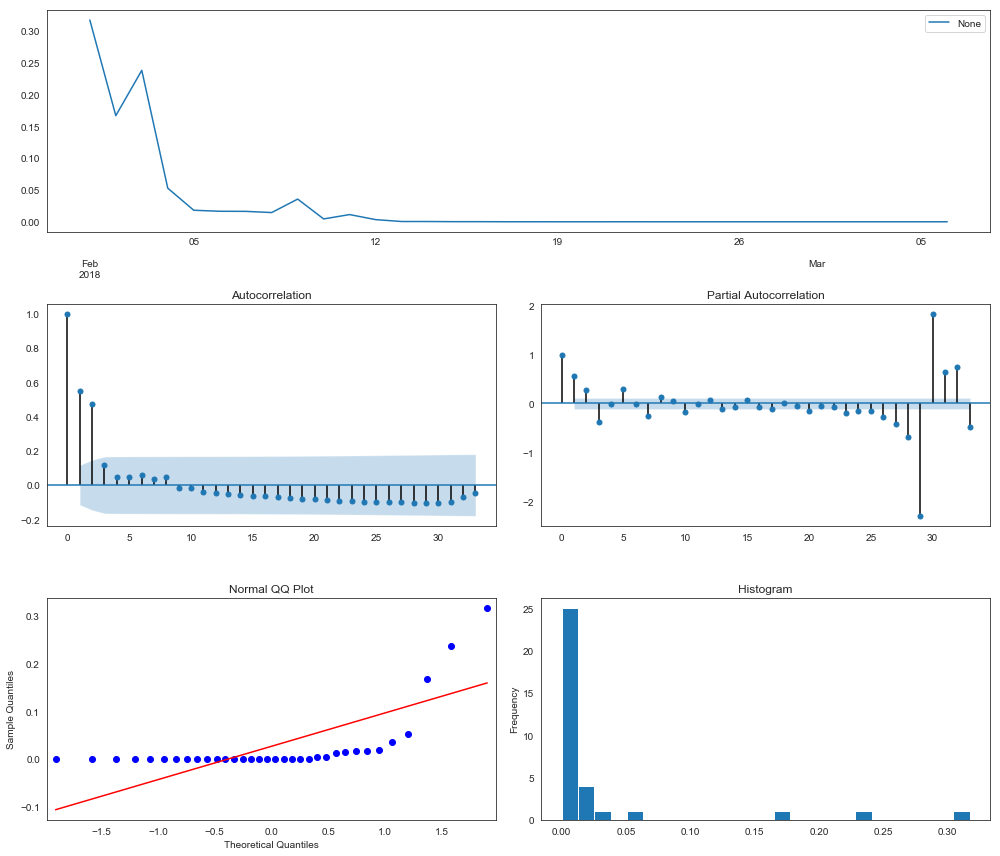

## Décomposition de la série de temps selon modèle multiplicatif

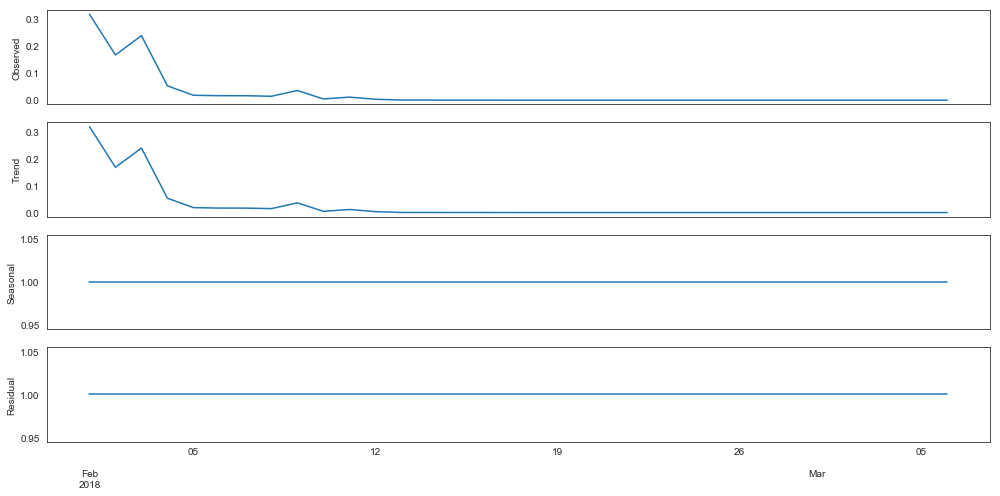

## Test de Dickey-Fuller

,Results of Augmented Dickey-Fuller test:
test statistic,-99.113206
p-value,0.000000
# of lags,10.000000
# of observations,23.000000
Critical Value (1%),-3.752928
Critical Value (5%),-2.998500
Critical Value (10%),-2.638967


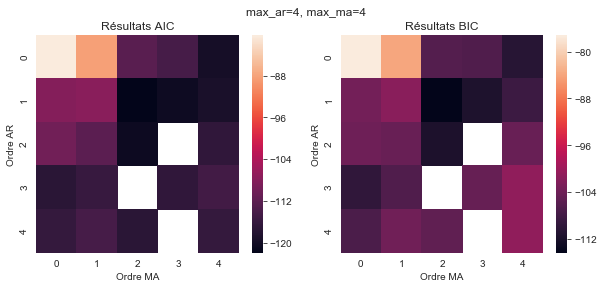

AIC meilleur modèle stationnaire : AR=0, MA=4, AIC=-119.66075748516639 
BIC meilleur modèle stationnaire : AR=0, MA=4, BIC=-110.50259433746942 


# Meilleur modèle selon AIC

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   34
Model:                     ARMA(0, 4)   Log Likelihood                  65.830
Method:                       css-mle   S.D. of innovations              0.031
Date:                Sat, 09 Feb 2019   AIC                           -119.661
Time:                        23:00:30   BIC                           -110.503
Sample:                             0   HQIC                          -116.538
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0303      0.022      1.390      0.175      -0.012       0.073
ma.L1.y        0.5632      0.154      3.647      0.001       0.261       0.866
ma.L2.y        1.6307      0.423      3.851      0.0

## Erreurs sur la période d'entraînement

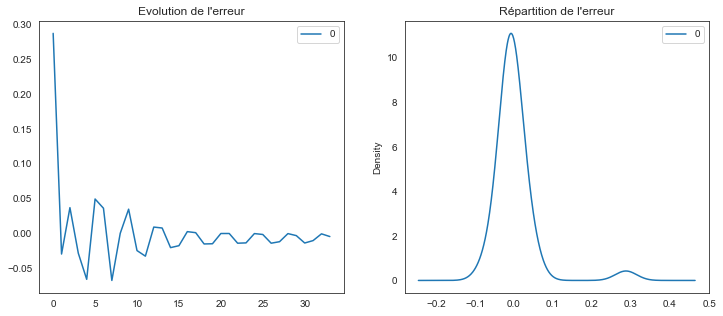

train_ratio= 0.25


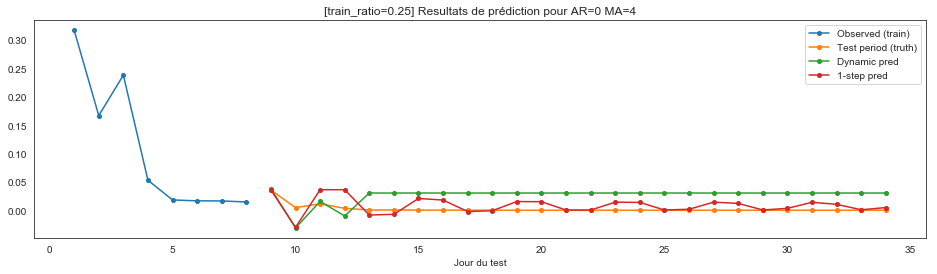

train_ratio= 0.5


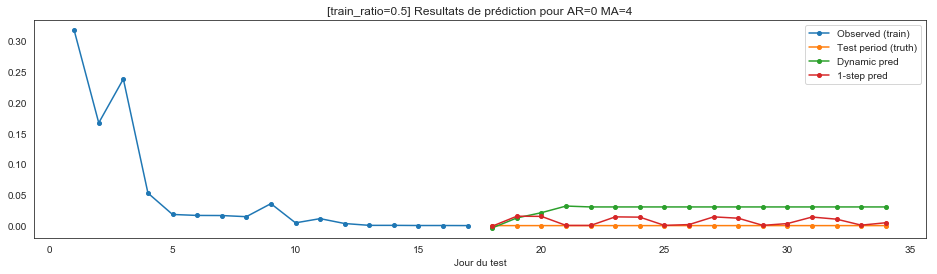

train_ratio= 0.75


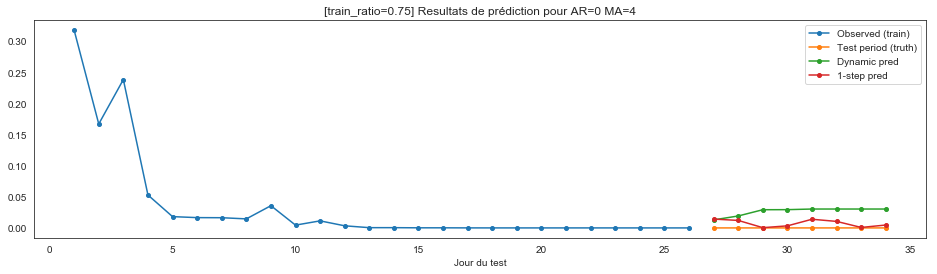

In [75]:
series = pd.Series(p_value_1D)
series.index = daily_cumsum_datasetA.index

analyserZP(series)

##################################### PARAMETRES #####################################
max_ar = 4
max_ma = 4
train_ratio_list = [0.25, 0.5, 0.75]
######################################################################################

aic_min_order, bic_min_order = arma_model_selection_stationary(series, max_ar=max_ar, max_ma=max_ma)

display(Markdown("# Meilleur modèle selon AIC"))
arma_summary(p=aic_min_order[0], q=aic_min_order[1], y_true=series.values)
if aic_min_order != bic_min_order:  
    display(Markdown("# Meilleur modèle selon BIC"))
    arma_summary(p=bic_min_order[0], q=bic_min_order[1], y_true=series.values)
    
for train_ratio in train_ratio_list:
    print("train_ratio=", train_ratio)
    in_sample_prediction(p=aic_min_order[0], q=aic_min_order[1], y_true=series.values, train_ratio=train_ratio)
    if aic_min_order != bic_min_order:
        in_sample_prediction(p=bic_min_order[0], q=bic_min_order[1], y_true=series.values, train_ratio=train_ratio)    

## Fit sur modèle tronqué

Si les résultats en fittant sur l'ensemble des données donnent des prévisions in-sample encore acceptables, nous nous intéressons aux prévisions out-of-sample à présent, si les résultats sont bons cela nous permettra de pouvoir arrêter les tests A/B plus tôt. Nous allons prendre 50% et 75% des données et observer la performance sur les modèles ARMA.

### train_ratio = 0.5

Si on entraîne sur la moitié des données (`train_ratio=0.5`), est-il possible d'avoir quand même un modèle permettant de prédire de manière convaincante la série des Z-valeurs ou des p-valeurs ?. 

In [76]:
Z_cum = pd.Series(Z_value_1D)
Z_cum.index = daily_cumsum_datasetA.index

P_rej = pd.Series(p_value_1D)
P_rej.index = daily_cumsum_datasetA.index

train_ratio = 0.5
t = round(train_ratio * len(Z_cum))
Z_tronq = Z_cum.iloc[0:t]
P_tronq = P_rej.iloc[0:t]

#### a. Etude sur Z

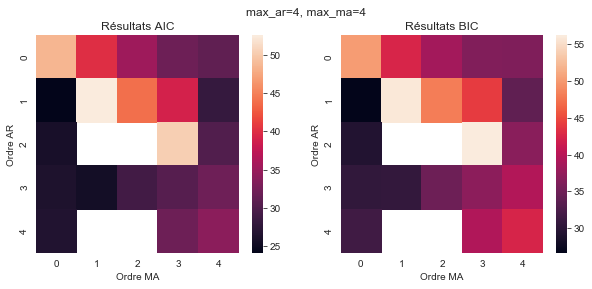

AIC meilleur modèle stationnaire : AR=1, MA=0, AIC=24.127272384716267 
BIC meilleur modèle stationnaire : AR=1, MA=0, BIC=26.626912416884917 


# Meilleur modèle selon AIC

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   17
Model:                     ARMA(1, 0)   Log Likelihood                  -9.064
Method:                       css-mle   S.D. of innovations              0.384
Date:                Sat, 09 Feb 2019   AIC                             24.127
Time:                        23:01:07   BIC                             26.627
Sample:                             0   HQIC                            24.376
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5557      1.100      2.323      0.035       0.399       4.712
ar.L1.y        0.9546      0.059     16.245      0.000       0.839       1.070
                                    Roots           

## Erreurs sur la période d'entraînement

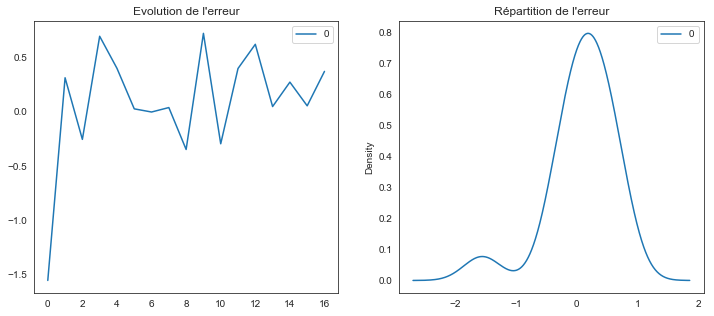

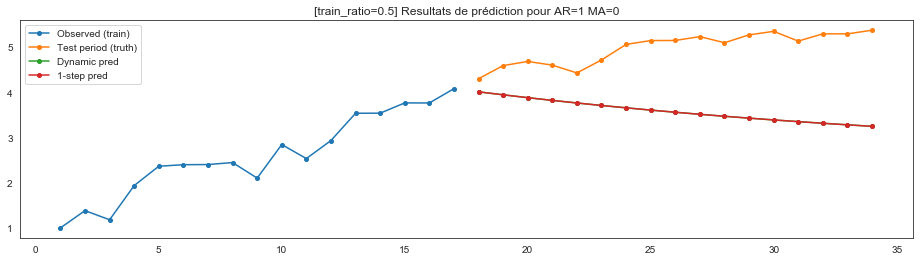

In [77]:
series = Z_tronq
y_true = Z_cum

##################################### PARAMETRES #####################################
max_ar = 4
max_ma = 4
######################################################################################

aic_min_order, bic_min_order = arma_model_selection_stationary(series, max_ar=max_ar, max_ma=max_ma)

display(Markdown("# Meilleur modèle selon AIC"))
arma_summary(p=aic_min_order[0], q=aic_min_order[1], y_true=series.values)
if aic_min_order != bic_min_order:  
    display(Markdown("# Meilleur modèle selon BIC"))
    arma_summary(p=bic_min_order[0], q=bic_min_order[1], y_true=series.values)
    
out_of_sample_prediction(p=aic_min_order[0], q=aic_min_order[1], y_true=y_true, train_ratio=train_ratio)
if aic_min_order != bic_min_order:  
    out_of_sample_prediction(p=bic_min_order[0], q=bic_min_order[1], y_true=y_true, train_ratio=train_ratio)

#### b. Etude sur p

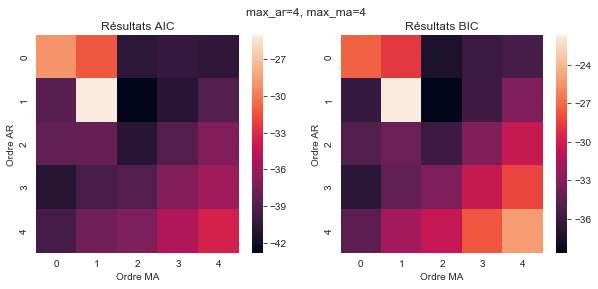

AIC meilleur modèle stationnaire : AR=3, MA=0, AIC=-40.957075314964214 
BIC meilleur modèle stationnaire : AR=0, MA=2, BIC=-37.36146770349089 


# Meilleur modèle selon AIC

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   17
Model:                     ARMA(3, 0)   Log Likelihood                  25.479
Method:                       css-mle   S.D. of innovations              0.050
Date:                Sat, 09 Feb 2019   AIC                            -40.957
Time:                        23:01:59   BIC                            -36.791
Sample:                             0   HQIC                           -40.543
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0798      0.067      1.188      0.256      -0.052       0.212
ar.L1.y        0.6706      0.197      3.396      0.005       0.284       1.058
ar.L2.y        0.7190      0.215      3.350      0.0

## Erreurs sur la période d'entraînement

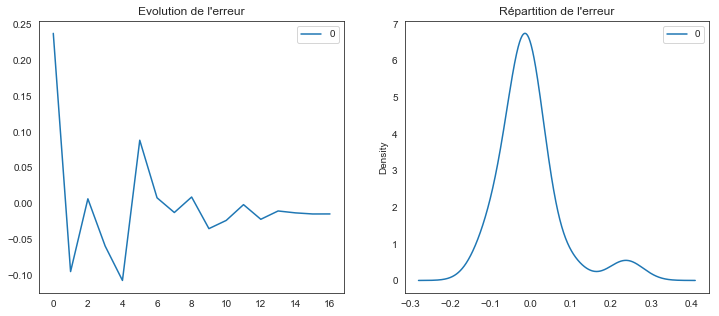

# Meilleur modèle selon BIC

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   17
Model:                     ARMA(0, 2)   Log Likelihood                  24.347
Method:                       css-mle   S.D. of innovations              0.051
Date:                Sat, 09 Feb 2019   AIC                            -40.694
Time:                        23:01:59   BIC                            -37.361
Sample:                             0   HQIC                           -40.363
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0584      0.029      2.037      0.061       0.002       0.115
ma.L1.y        0.4641      0.199      2.332      0.035       0.074       0.854
ma.L2.y        0.9999      0.235      4.263      0.0

## Erreurs sur la période d'entraînement

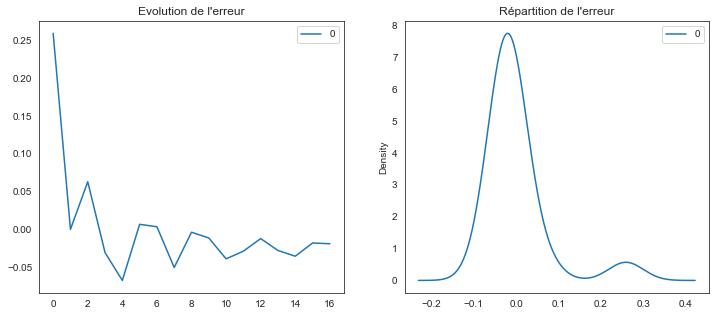

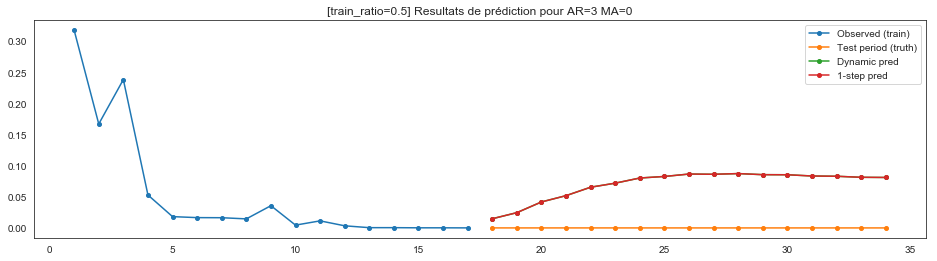

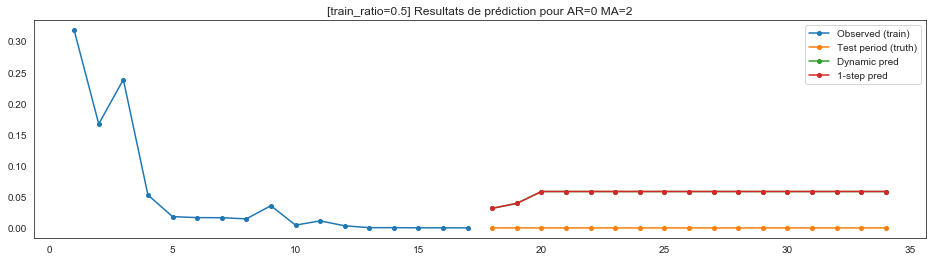

In [79]:
series = P_tronq
y_true = P_rej

##################################### PARAMETRES #####################################
max_ar = 4
max_ma = 4
######################################################################################

aic_min_order, bic_min_order = arma_model_selection_stationary(series, max_ar=max_ar, max_ma=max_ma)

display(Markdown("# Meilleur modèle selon AIC"))
arma_summary(p=aic_min_order[0], q=aic_min_order[1], y_true=series.values)
if aic_min_order != bic_min_order:  
    display(Markdown("# Meilleur modèle selon BIC"))
    arma_summary(p=bic_min_order[0], q=bic_min_order[1], y_true=series.values)
    
out_of_sample_prediction(p=aic_min_order[0], q=aic_min_order[1], y_true=y_true.values, train_ratio=train_ratio)
if aic_min_order != bic_min_order:  
    out_of_sample_prediction(p=bic_min_order[0], q=bic_min_order[1], y_true=y_true.values, train_ratio=train_ratio)

### train_ratio = 0.75
On entraîne sur 75% des données (`train_ratio=0.75`). 

In [80]:
Z_cum = pd.Series(Z_value_1D)
Z_cum.index = daily_cumsum_datasetA.index

P_rej = pd.Series(p_value_1D)
P_rej.index = daily_cumsum_datasetA.index

train_ratio = 0.75
t = round(train_ratio * len(Z_cum))
Z_tronq = Z_cum[0:t]
P_tronq = P_rej[0:t]

#### a. Etude sur Z

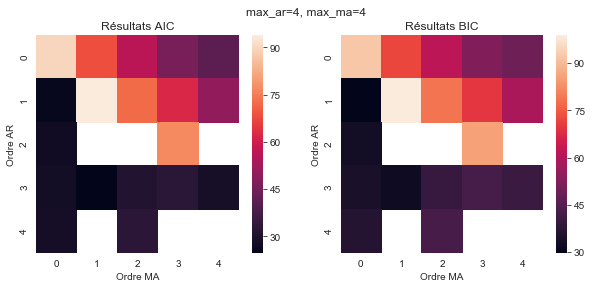

AIC meilleur modèle stationnaire : AR=3, MA=1, AIC=24.80087948385848 
BIC meilleur modèle stationnaire : AR=1, MA=0, BIC=29.696834401215963 


# Meilleur modèle selon AIC

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   26
Model:                     ARMA(3, 1)   Log Likelihood                  -6.400
Method:                       css-mle   S.D. of innovations              0.275
Date:                Sat, 09 Feb 2019   AIC                             24.801
Time:                        23:02:36   BIC                             32.349
Sample:                             0   HQIC                            26.975
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8635      0.852      3.362      0.003       1.194       4.533
ar.L1.y        1.6817      0.191      8.813      0.000       1.308       2.056
ar.L2.y       -0.3877      0.382     -1.015      0.3

## Erreurs sur la période d'entraînement

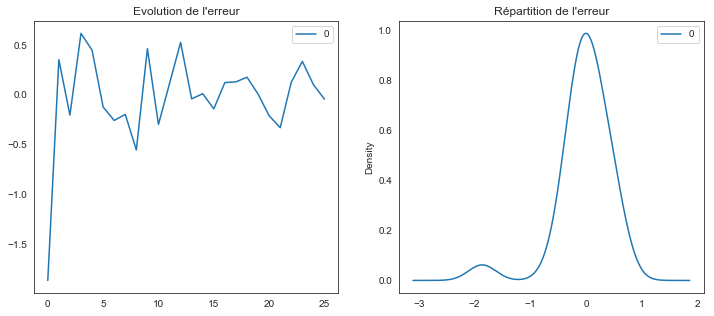

# Meilleur modèle selon BIC

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   26
Model:                     ARMA(1, 0)   Log Likelihood                  -9.961
Method:                       css-mle   S.D. of innovations              0.332
Date:                Sat, 09 Feb 2019   AIC                             25.923
Time:                        23:02:36   BIC                             29.697
Sample:                             0   HQIC                            27.009
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1176      1.710      1.823      0.081      -0.234       6.469
ar.L1.y        0.9841      0.021     46.367      0.000       0.943       1.026
                                    Roots           

## Erreurs sur la période d'entraînement

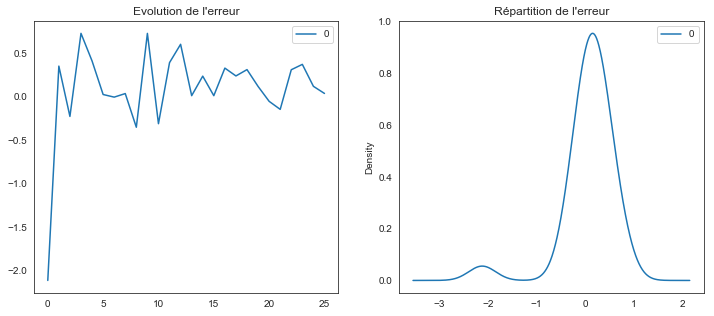

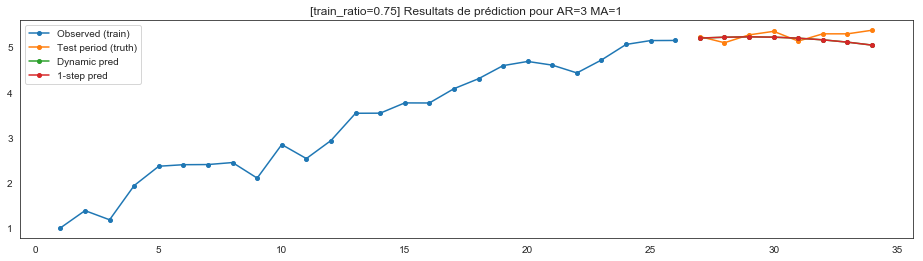

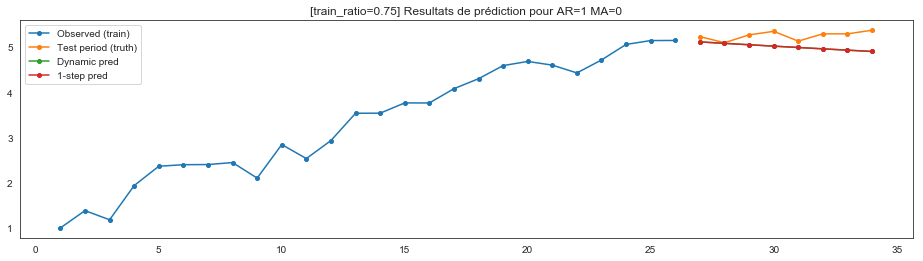

In [82]:
series = Z_tronq
y_true = Z_cum

##################################### PARAMETRES #####################################
max_ar = 4
max_ma = 4
######################################################################################

aic_min_order, bic_min_order = arma_model_selection_stationary(series, max_ar=max_ar, max_ma=max_ma)

display(Markdown("# Meilleur modèle selon AIC"))
arma_summary(p=aic_min_order[0], q=aic_min_order[1], y_true=series.values)
if aic_min_order != bic_min_order:  
    display(Markdown("# Meilleur modèle selon BIC"))
    arma_summary(p=bic_min_order[0], q=bic_min_order[1], y_true=series.values)
    
out_of_sample_prediction(p=aic_min_order[0], q=aic_min_order[1], y_true=y_true, train_ratio=train_ratio)
if aic_min_order != bic_min_order:  
    out_of_sample_prediction(p=bic_min_order[0], q=bic_min_order[1], y_true=y_true, train_ratio=train_ratio)

#### b. Etude sur p

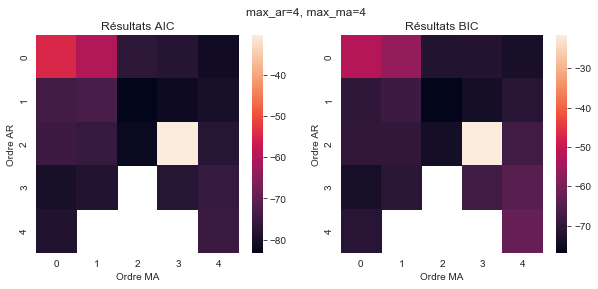

AIC meilleur modèle stationnaire : AR=0, MA=4, AIC=-80.86478842665916 
BIC meilleur modèle stationnaire : AR=3, MA=0, BIC=-73.55102258982144 


# Meilleur modèle selon AIC

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   26
Model:                     ARMA(0, 4)   Log Likelihood                  46.432
Method:                       css-mle   S.D. of innovations              0.035
Date:                Sat, 09 Feb 2019   AIC                            -80.865
Time:                        23:03:19   BIC                            -73.316
Sample:                             0   HQIC                           -78.691
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0396      0.027      1.449      0.162      -0.014       0.093
ma.L1.y        0.5649      0.173      3.259      0.004       0.225       0.905
ma.L2.y        1.5724      0.476      3.306      0.0

## Erreurs sur la période d'entraînement

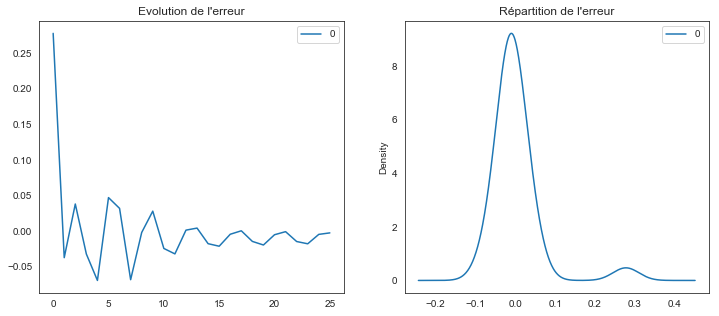

# Meilleur modèle selon BIC

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   26
Model:                     ARMA(3, 0)   Log Likelihood                  44.921
Method:                       css-mle   S.D. of innovations              0.040
Date:                Sat, 09 Feb 2019   AIC                            -79.842
Time:                        23:03:20   BIC                            -73.551
Sample:                             0   HQIC                           -78.030
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0673      0.067      1.006      0.325      -0.064       0.199
ar.L1.y        0.6885      0.166      4.153      0.000       0.364       1.013
ar.L2.y        0.7745      0.178      4.353      0.0

## Erreurs sur la période d'entraînement

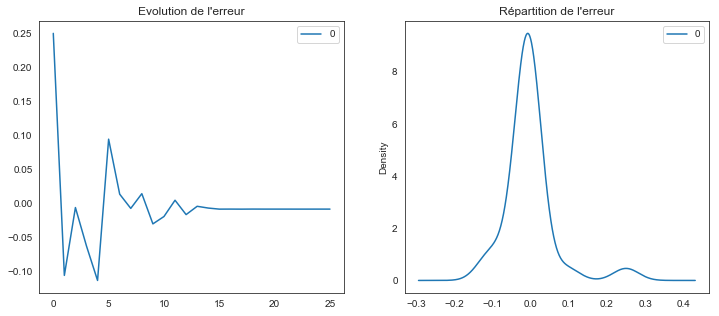

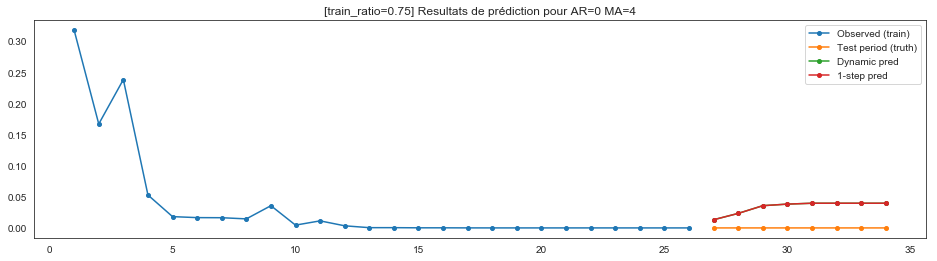

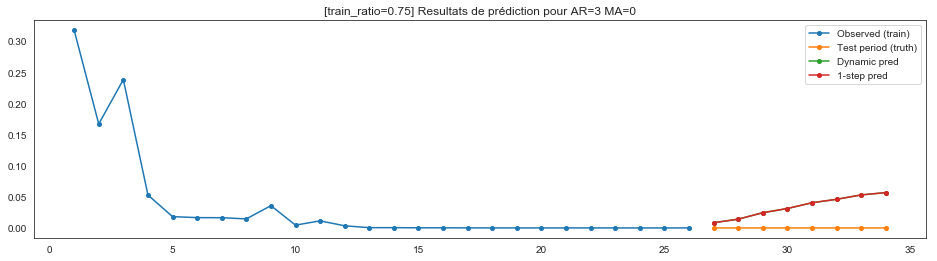

In [83]:
series = P_tronq
y_true = P_rej

##################################### PARAMETRES #####################################
max_ar = 4
max_ma = 4
######################################################################################

aic_min_order, bic_min_order = arma_model_selection_stationary(series, max_ar=max_ar, max_ma=max_ma)

display(Markdown("# Meilleur modèle selon AIC"))
arma_summary(p=aic_min_order[0], q=aic_min_order[1], y_true=series.values)
if aic_min_order != bic_min_order:  
    display(Markdown("# Meilleur modèle selon BIC"))
    arma_summary(p=bic_min_order[0], q=bic_min_order[1], y_true=series.values)
    
out_of_sample_prediction(p=aic_min_order[0], q=aic_min_order[1], y_true=y_true.values, train_ratio=train_ratio)
if aic_min_order != bic_min_order:  
    out_of_sample_prediction(p=bic_min_order[0], q=bic_min_order[1], y_true=y_true.values, train_ratio=train_ratio)